# Testing GISSR-style inundation on ideal topo

Imports and setups

In [7]:
import pandas as pd
import numpy as np

import params_ideal as params

from fun_ideal import calc_flood_height, generate_groups, calc_group_vol, calc_group_h
from ideal_damage import Damage
from topo_ideal import Topo

In [8]:
topo_file = "ideal_topo_gp_points_1.csv"
storm_file = "SurgeData/surge_w.csv"
div_data_file = "ideal_div_data.csv"
time_file = "SurgeData/time_w.csv"
damage_table_file = "damage_table.csv"

In [9]:
surge = pd.read_csv(storm_file).values
surge_time = pd.read_csv(time_file).values
damage_table = pd.read_csv(damage_table_file)


Topo = Topo(topo_file=topo_file)
Damage = Damage(damage_table_file)

In [10]:
# generate groups
#groups = generate_groups(Topo.div_data)

segment_l = 100
wall_height = np.zeros(Topo.shore_height.size)


# Calculate indundation with varying sized walls
Equal height wall for all divs in divs_allocate

In [6]:
divs_allocate = list(range(18))
groups = generate_groups(Topo.div_data)

positions = []
for i, p in enumerate(wall_height):
    if Topo.all_divs[i] in divs_allocate:
        positions.append(i)
        
h_start = 0
h_end = 0
h_num = 1

points = []
wall_height[positions] = h_start

for h in np.linspace(h_start, h_end, num=h_num):
    wall_height[:] = 0
    wall_height[positions] = h

    height_div, volume_div = calc_flood_height(Topo, surge, surge_time, wall_height, positions)

    # calculate group volumes
    volume_grouped = calc_group_vol(groups, volume_div)

    # get height in each group
    surge_peak = np.amax(surge, axis=1)
    height_grouped = calc_group_h(Topo, groups, volume_grouped, surge_peak)

    #Damage
    dmg = Damage.calc_damage(height_grouped)
    cost_dmg = np.sum(dmg)
    cost_wall = np.sum(49212 * wall_height * segment_l)
    cost_tot = cost_dmg + cost_wall

    points.append([h, cost_wall, cost_dmg, cost_tot])

    
df = pd.DataFrame(points)

2


# Inundation with varying travel distance for redistribution

In [17]:
divs_allocate = list(range(18))

positions = []
for i, p in enumerate(wall_height):
    if Topo.all_divs[i] in divs_allocate:
        positions.append(i)
        
h_start = 0
h_end = 0
h_num = 1

points = []
wall_height[positions] = h_start

data = []
for r in range(18):
    params.travel_dist = r
    groups = generate_groups(Topo.div_data)

    for h in np.linspace(h_start, h_end, num=h_num):
        wall_height[:] = 0
        wall_height[positions] = h

        height_div, volume_div = calc_flood_height(Topo, surge, surge_time, wall_height, positions)

        # calculate group volumes
        volume_grouped = calc_group_vol(groups, volume_div)

        # get height in each group
        surge_peak = np.amax(surge, axis=1)
        height_grouped = calc_group_h(Topo, groups, volume_grouped, surge_peak)
        
        #Damage
        dmg = Damage.calc_damage(height_grouped)
        cost_dmg = np.sum(dmg)
        cost_wall = np.sum(49212 * wall_height * segment_l)
        cost_tot = cost_dmg + cost_wall

        points.append([h, cost_wall, cost_dmg, cost_tot])

        data.append(height_grouped[4])
        print(height_grouped)
        print("foo")
        #print(np.max(np.max(height_grouped, axis=1) - np.min(height_grouped, axis=1)))

df = pd.DataFrame(data)
df.to_csv("ideal_test_travel.csv")

[[ 4.50854578  5.08462606  4.20254228  4.94841218  5.09432191  5.67015333
   3.73776307  0.79172037  0.77261331  1.04221531  3.59026201  2.35708732
   2.37556657  1.60130317  2.35636302  2.96483479  4.97258743  4.03626121]
 [ 0.28807437  0.3258488   0.28807437  0.33263963  0.33263963  0.33263963
   0.23521174  0.          0.          0.          0.16631981  0.
   0.          0.          0.          0.          0.28807437  0.21605994]
 [ 0.23389083  0.26304506  0.23389083  0.27007387  0.27007387  0.27007387
   0.19097107  0.          0.          0.          0.13503694  0.
   0.          0.          0.          0.          0.23389083  0.16806562]
 [ 4.05097162  4.55842132  3.77004011  4.44005428  4.58244429  5.04609091
   3.3470209   0.56827239  0.45555759  0.72599343  3.16872623  1.90299896
   1.85428143  1.00071318  1.98306307  2.53813971  4.41312728  3.59320879]
 [ 1.96195534  2.21774922  1.85748597  2.14668965  2.23587203  2.27976633
   1.57721334  0.          0.          0.         

[[ 4.94016374  4.78691937  4.48649362  4.23773959  4.03375934  3.99547614
   3.82374164  3.57543253  3.37805358  3.11286728  2.85127562  2.73035939
   2.78616878  2.90990004  3.05451278  3.21631377  3.16029084  3.27276046]
 [ 0.31730597  0.30692555  0.28710256  0.27068289  0.25679234  0.24992459
   0.23434599  0.21275702  0.1942197   0.16631981  0.13267731  0.12283532
   0.12110586  0.1269456   0.13372073  0.14171097  0.13790613  0.14873835]
 [ 0.25736558  0.24896706  0.23288736  0.21956831  0.20830079  0.20273744
   0.19007707  0.17273983  0.15768917  0.13503694  0.10772221  0.09973139
   0.09701926  0.10169754  0.10712518  0.11352625  0.11017162  0.11882536]
 [ 4.42678758  4.28920969  4.01721564  3.79051015  3.60331474  3.56599593
   3.39907248  3.15867903  2.96246228  2.7095197   2.45319504  2.33962864
   2.3897718   2.4986326   2.62766132  2.77300049  2.71284454  2.82308889]
 [ 2.12221069  2.0532299   1.9206207   1.81077857  1.71785538  1.69219453
   1.59426267  1.44728382  1.33453

[[ 3.88542132  3.79069004  3.67778538  3.60479238  3.56815925  3.66569785
   3.68978177  3.68978177  3.68978177  3.68978177  3.68978177  3.68978177
   3.63627818  3.52692602  3.47763436  3.34911501  3.17708408  2.87658612]
 [ 0.23928458  0.22989719  0.22153447  0.21402264  0.20722653  0.21283412
   0.21303577  0.21303577  0.21303577  0.21303577  0.21303577  0.21303577
   0.20781835  0.1981973   0.19076846  0.17645257  0.15835823  0.13423808]
 [ 0.19410632  0.18649132  0.17970753  0.17361397  0.168101    0.1726663
   0.17238432  0.17238432  0.17238432  0.17238432  0.17238432  0.17238432
   0.16809868  0.16036997  0.1542792   0.14255977  0.12772785  0.10790857]
 [ 3.45809439  3.36199759  3.25072287  3.181963    3.145587    3.23393016
   3.2573839   3.2573839   3.2573839   3.2573839   3.2573839   3.2573839
   3.20497647  3.10165388  3.05230912  2.92924655  2.76302885  2.48272426]
 [ 1.62807854  1.56423034  1.50733007  1.45732839  1.43388197  1.47450502
   1.48997348  1.48997348  1.4899734

[[ 3.56815925  3.66569785  3.68978177  3.68978177  3.68978177  3.68978177
   3.68978177  3.68978177  3.68978177  3.68978177  3.68978177  3.68978177
   3.68978177  3.68978177  3.68978177  3.68978177  3.63627818  3.52692602]
 [ 0.20722653  0.21283412  0.21303577  0.21303577  0.21303577  0.21303577
   0.21303577  0.21303577  0.21303577  0.21303577  0.21303577  0.21303577
   0.21303577  0.21303577  0.21303577  0.21303577  0.20781835  0.1981973 ]
 [ 0.168101    0.1726663   0.17238432  0.17238432  0.17238432  0.17238432
   0.17238432  0.17238432  0.17238432  0.17238432  0.17238432  0.17238432
   0.17238432  0.17238432  0.17238432  0.17238432  0.16809868  0.16036997]
 [ 3.145587    3.23393016  3.2573839   3.2573839   3.2573839   3.2573839
   3.2573839   3.2573839   3.2573839   3.2573839   3.2573839   3.2573839
   3.2573839   3.2573839   3.2573839   3.2573839   3.20497647  3.10165388]
 [ 1.43388197  1.47450502  1.48997348  1.48997348  1.48997348  1.48997348
   1.48997348  1.48997348  1.4899734

# PLOT


In [18]:
print(df)

          0         1         2         3         4         5         6   \
0   1.961955  2.217749  1.857486  2.146690  2.235872  2.279766  1.577213   
1   2.093762  2.018079  2.079819  2.086277  2.221466  2.056215  1.600514   
2   2.018079  2.050988  2.089274  2.152831  2.036791  1.859695  1.592737   
3   2.050988  2.089274  2.122211  2.053230  1.914643  1.721403  1.571730   
4   2.089274  2.122211  2.053230  1.920621  1.810779  1.688556  1.589237   
5   2.122211  2.053230  1.920621  1.810779  1.717855  1.692195  1.594263   
6   2.053230  1.920621  1.810779  1.717855  1.692195  1.628079  1.564230   
7   1.920621  1.810779  1.717855  1.692195  1.628079  1.564230  1.507330   
8   1.810779  1.717855  1.692195  1.628079  1.564230  1.507330  1.457328   
9   1.717855  1.692195  1.628079  1.564230  1.507330  1.457328  1.433882   
10  1.692195  1.628079  1.564230  1.507330  1.457328  1.433882  1.474505   
11  1.628079  1.564230  1.507330  1.457328  1.433882  1.474505  1.489973   
12  1.564230

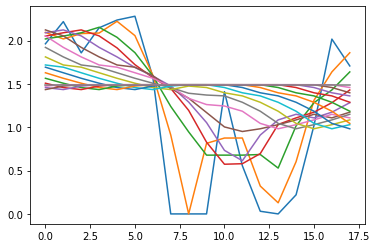

In [20]:
import matplotlib.pyplot as plt

divs = list(range(18))
for div in divs:
    plt.plot(divs, data[div], label=div)
#plt.legend()
plt.show()